# Plant Talk: Translating Plant Bio-Signals into Meaningful Messages

We aim to build a classifier that translates plant bio-signals into four message types:
- Warning
- Contentment
- Distress
- Invitation

Besides, we compare:
1. **Baseline model** — uses only external/environmental features  
2. **Full model** — baseline + direct plant bio-signals
3. **Full model+clustering** — baseline + direct plant bio-signals + clustering features

We test multiple ML models (RF, SVM, XGBoost, MLP Neural Network) and interpret results.


# 1. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
import xgboost as xgb
import math
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif

In [2]:
RANDOM_STATE = 42
df = pd.read_csv("alien_plant_communication_dataset.csv")
baseline_features = [
    "Ambient_Temperature_C", "Soil_Moisture_Level", 
    "Sunlight_Exposure_Hours", "Growth_Rate_mm_day"
]
bio_features = [
    "Leaf_Vibration_Hz", "Pollen_Scent_Complexity", 
    "Bioluminescence_Intensity_Lux", "Root_Signal_Strength_mV"
]
binary_feature = ["Symbiotic_Fungus_Present"]
full_features = baseline_features + bio_features + binary_feature
target_column = "Plant_Message_Type"

# 2. EDA

## 2.1 Target Variable Analysis

/var/folders/7w/3d5phc9d74z_t1zf0949fsrh0000gn/T/ipykernel_10396/3201479243.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[target_column], palette="viridis")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_g

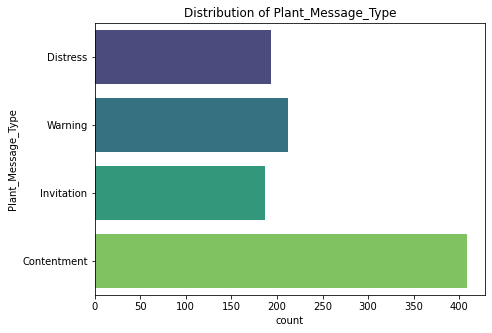

<Figure size 432x288 with 0 Axes>

In [3]:
plt.figure(figsize=(7, 5))
sns.countplot(y=df[target_column], palette="viridis")
plt.title(f"Distribution of {target_column}")
plt.show()
plt.clf()

## 2.2 Independent Variable Analysis

### 2.2.1 Feature Distribution

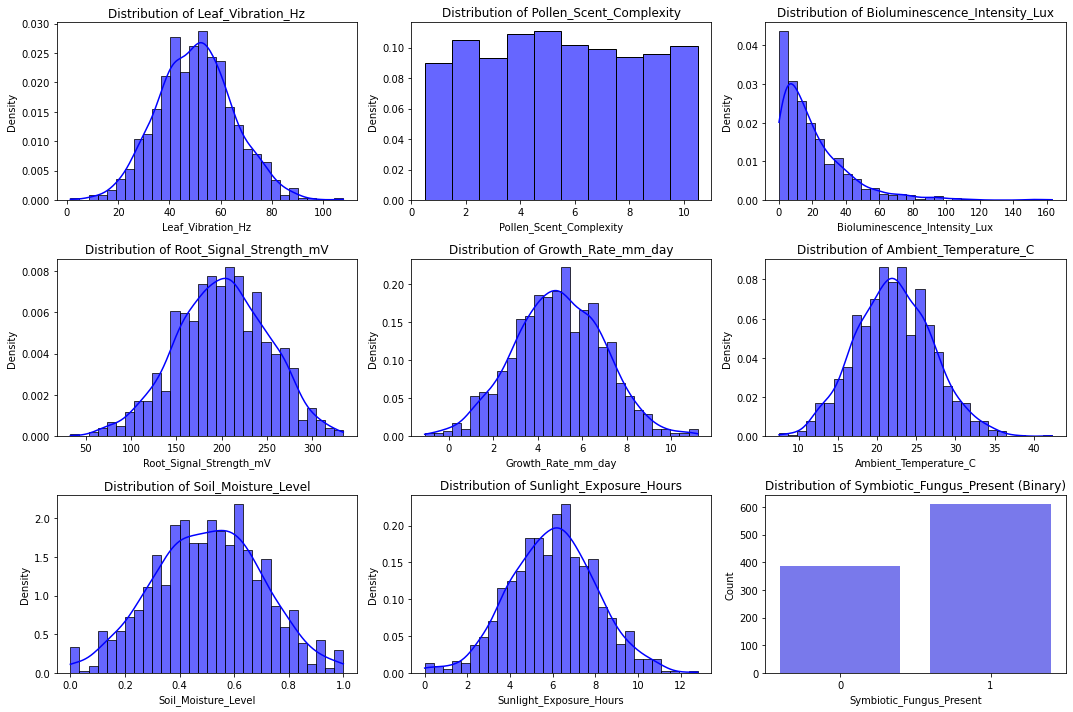

In [4]:
# 2. Explore distribution of numerical variables
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    
    if feature == 'Pollen_Scent_Complexity':
        sns.histplot(df[feature], discrete=True, color='blue', stat='density', alpha=0.6, kde=False)
        plt.title(f"Distribution of {feature}")
        
    elif feature == 'Symbiotic_Fungus_Present':
        sns.countplot(x=df[feature], color='blue', alpha=0.6)
        plt.title(f"Distribution of {feature} (Binary)")
        
    else:
        sns.histplot(df[feature], kde=True, bins=30, color='blue', stat='density', alpha=0.6)
        plt.title(f"Distribution of {feature}")

    plt.xlabel(feature)
    plt.ylabel("Density" if feature != 'Symbiotic_Fungus_Present' else "Count")
    
plt.tight_layout()
plt.show()

### 2.2.2 Correlation & Multicollinearity

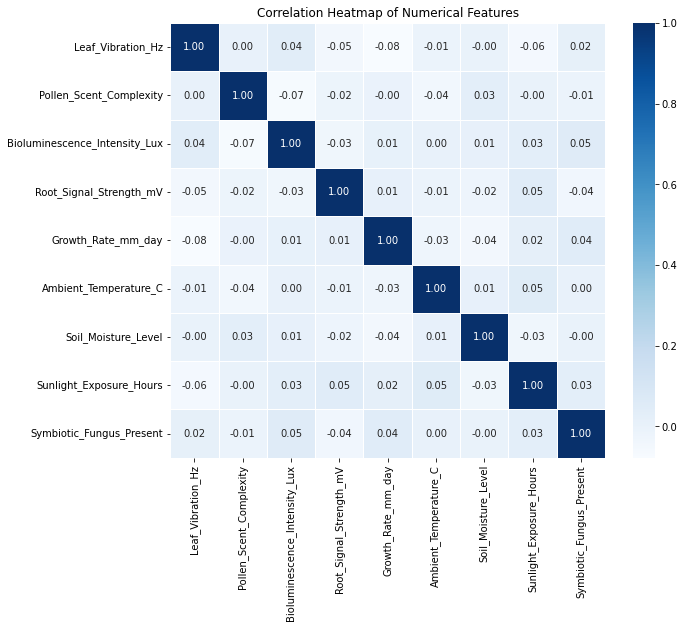

<Figure size 432x288 with 0 Axes>

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numerical_features].corr(),
    annot=True,
    fmt=".2f",
    cmap="Blues",        # 蓝色系
    linewidths=0.5,
    linecolor="white",
    square=True
)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()
plt.clf()

## 2.3 Impact Analysis

### 2.3.1 Single Feature Impact

/var/folders/7w/3d5phc9d74z_t1zf0949fsrh0000gn/T/ipykernel_10396/3661326251.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:9

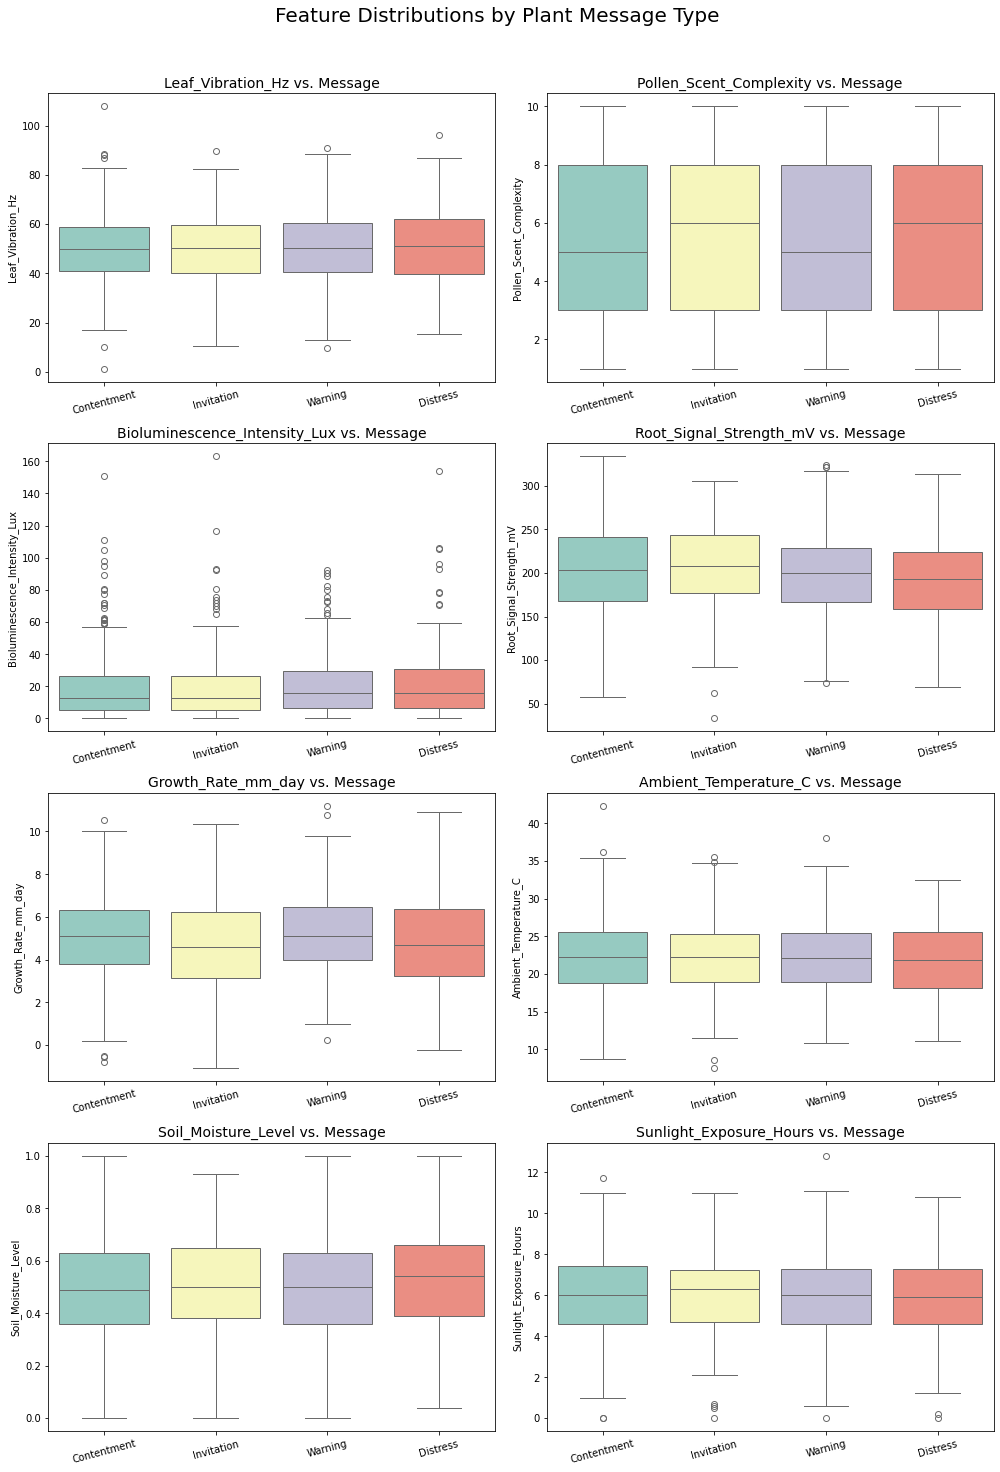

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


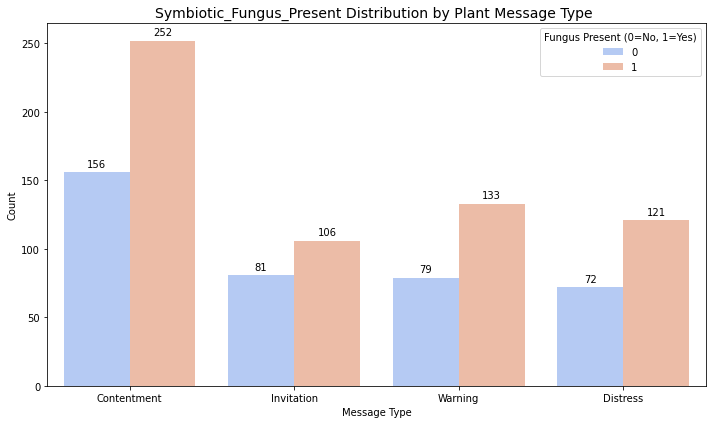

In [6]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Clean up the feature list for the boxplots
binary_feature_name = binary_feature[0] if isinstance(binary_feature, (list, tuple)) else binary_feature
features_to_plot = [
    f for f in numerical_features
    if f not in {binary_feature_name, 'Plant_ID', 'Symbiotic'}
]

cols = 2
rows = math.ceil(len(features_to_plot) / cols)

plt.figure(figsize=(14, 5 * rows))
plt.suptitle('Feature Distributions by Plant Message Type ', fontsize=20, y=1.02)

for i, feature in enumerate(features_to_plot):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(
        data=df,
        x=target_column,
        y=feature,
        palette='Set3',
        order=['Contentment', 'Invitation', 'Warning', 'Distress']
    )
    plt.title(f'{feature} vs. Message', fontsize=14)
    plt.xlabel('')
    plt.ylabel(feature)
    plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

# Separate distribution figure with annotations
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df,
    x=target_column,
    hue=binary_feature_name,
    palette='coolwarm',
    order=['Contentment', 'Invitation', 'Warning', 'Distress']
)

plt.title(f'{binary_feature_name} Distribution by Plant Message Type ', fontsize=14)
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.legend(title='Fungus Present (0=No, 1=Yes)', loc='upper right')

for patch in ax.patches:
    height = int(patch.get_height())
    if height > 0:
        ax.annotate(
            f'{height}',
            (patch.get_x() + patch.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            xytext=(0, 3),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()


No difference in features distribution among the 4 target classification groups, which implies that no any single feature has significant impact on target variable.

To further explore whether the combination of features have impact, conduct PCA to see whether the PC can classifiy the data points. For EDA purpose only, select n_components=2 for visualization.

### 2.3.2 Feature Combination Impact

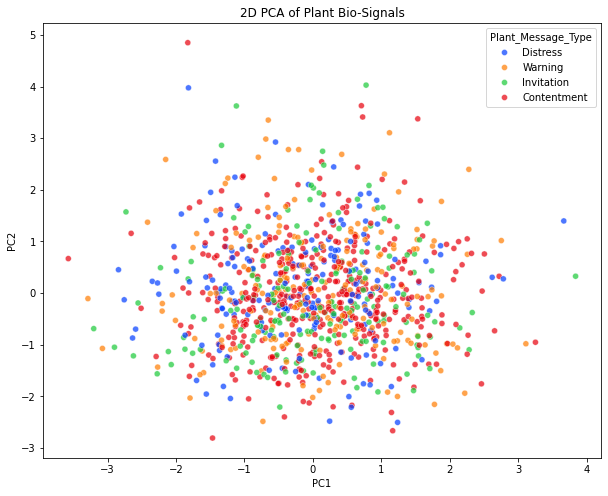

In [7]:
features = df.drop(['Plant_Message_Type', 'Plant_ID'], axis=1)
y = df['Plant_Message_Type']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Plant_Message_Type', palette='bright', alpha=0.7)
plt.title('2D PCA of Plant Bio-Signals')
plt.show()

Still, the 4 groups mix together, showing that the data is noisy and the impact of independent features on target variable is hidden.

Since the independent features are divided into baseline features and bio features, in the modeling part, we would like to further investigate whether these two types of features have different impact on the target varible.

# 3. Modeling

In [8]:
# Data processing before modeling

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(df[target_column])
y_labels = df[target_column].unique() 

#  Split dataset based on baseline features and full features
X_base_raw = df[baseline_features]
X_full_raw = df[full_features]

# Train-test split
X_train_b, X_test_b, y_train, y_test = train_test_split(
    X_base_raw, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded)

X_train_f, X_test_f, _, _ = train_test_split(
    X_full_raw, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded)

#  Apply Scaling
scaler = StandardScaler()
X_train_b = scaler.fit_transform(X_train_b[baseline_features])
X_test_b = scaler.transform(X_test_b[baseline_features])
X_train_f = scaler.fit_transform(X_train_f[full_features])
X_test_f = scaler.transform(X_test_f[full_features])

X_train_b = pd.DataFrame(X_train_b, columns=baseline_features)
X_test_b  = pd.DataFrame(X_test_b,  columns=baseline_features)
X_train_f = pd.DataFrame(X_train_f, columns=full_features)
X_test_f  = pd.DataFrame(X_test_f,  columns=full_features)

## 3.1 Clustering

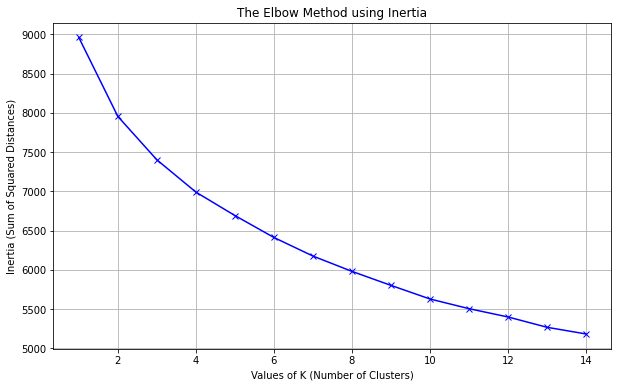

In [9]:
X_clustering_data = pd.concat([X_train_f, X_test_f])

k_range = range(1, 15)
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_clustering_data)
    inertias.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Values of K (Number of Clusters)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('The Elbow Method using Inertia')
plt.grid(True)
plt.show()

According to the elbow method, here we select k=4 as the best k.

In [10]:
best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10) 
X_full_for_clustering = pd.concat([X_train_f, X_test_f])
kmeans.fit(X_full_for_clustering)

# Add 'Cluster' feature to FUll datasets (Train/Test)
X_train_f_clustered = X_train_f.copy()
X_test_f_clustered  = X_test_f.copy()
X_train_f_clustered['Clustering'] = kmeans.predict(X_train_f_clustered[full_features])
X_test_f_clustered['Clustering']  = kmeans.predict(X_test_f_clustered[full_features])

# Update feature lists
baseline_features_clustered = baseline_features + ['Clustering']
full_features_clustered = full_features + ['Clustering']


X_test_f_scaled_df = pd.DataFrame(X_test_f, columns=full_features_clustered)

## 3.2 Classification

### 3.2.1 Model Evaluation Function

### 3.2.2 Random Forest

In [11]:
# Hyperparameter Tuning for Random Forest
rf_tune = RandomForestClassifier(random_state=RANDOM_STATE)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=rf_tune, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train_f, y_train)
best_rf = grid_search.best_estimator_
print(f"Best Tuned Random Forest Parameters: {grid_search.best_params_}")

Best Tuned Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [12]:
rf_base      = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train_b, y_train)
rf_full      = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train_f, y_train)
rf_full_clus = RandomForestClassifier(random_state=RANDOM_STATE).fit(X_train_f_clustered, y_train)

### 3.2.3 XG Boost

In [13]:
xgb_base      = xgb.XGBClassifier(
                    objective='multi:softmax', num_class=len(y_labels),
                    eval_metric='mlogloss', random_state=RANDOM_STATE, use_label_encoder=False
                ).fit(X_train_b, y_train)
xgb_full      = xgb.XGBClassifier(
                    objective='multi:softmax', num_class=len(y_labels),
                    eval_metric='mlogloss', random_state=RANDOM_STATE, use_label_encoder=False
                ).fit(X_train_f, y_train)
xgb_full_clus = xgb.XGBClassifier(
                    objective='multi:softmax', num_class=len(y_labels),
                    eval_metric='mlogloss', random_state=RANDOM_STATE, use_label_encoder=False
                ).fit(X_train_f_clustered, y_train)

### 3.2.4 SVM

In [14]:
svm_base      = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE).fit(X_train_b, y_train)
svm_full      = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE).fit(X_train_f, y_train)
svm_full_clus = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE).fit(X_train_f_clustered, y_train)

### 3.2.5 MLP

In [15]:
mlp_base      = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500,
                              random_state=RANDOM_STATE, early_stopping=True).fit(X_train_b, y_train)
mlp_full      = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500,
                              random_state=RANDOM_STATE, early_stopping=True).fit(X_train_f, y_train)
mlp_full_clus = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500,
                              random_state=RANDOM_STATE, early_stopping=True).fit(X_train_f_clustered, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid 

## 3.3 Model Evaluation

### 3.3.1 Result and Visualization

In [16]:
# Define model evaluation function
def eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    auc_macro = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    
    return acc, f1, auc_macro

In [17]:
results = pd.DataFrame({
    "Model": [
        "RandomForest (Baseline)",   "RandomForest (Full)",   "RandomForest (FullClustering)",
        "XGBoost (Baseline)",  "XGBoost (Full)",  "XGBoost (FullClustering)",
        "SVM (Baseline)",  "SVM (Full)",  "SVM (FullClustering)",
        "MLP (Baseline)",  "MLP (Full)",  "MLP (FullClustering)"
    ],
    "Accuracy": [
        eval(rf_base,      X_test_b, y_test)[0],
        eval(rf_full,      X_test_f, y_test)[0],
        eval(rf_full_clus, X_test_f_clustered, y_test)[0],

        eval(xgb_base,      X_test_b, y_test)[0],
        eval(xgb_full,      X_test_f, y_test)[0],
        eval(xgb_full_clus, X_test_f_clustered, y_test)[0],

        eval(svm_base,      X_test_b, y_test)[0],
        eval(svm_full,      X_test_f, y_test)[0],
        eval(svm_full_clus, X_test_f_clustered, y_test)[0],

        eval(mlp_base,      X_test_b, y_test)[0],
        eval(mlp_full,      X_test_f, y_test)[0],
        eval(mlp_full_clus, X_test_f_clustered, y_test)[0],
    ],
    "F1-Macro": [
        eval(rf_base,      X_test_b, y_test)[1],
        eval(rf_full,      X_test_f, y_test)[1],
        eval(rf_full_clus, X_test_f_clustered, y_test)[1],

        eval(xgb_base,      X_test_b, y_test)[1],
        eval(xgb_full,      X_test_f, y_test)[1],
        eval(xgb_full_clus, X_test_f_clustered, y_test)[1],

        eval(svm_base,      X_test_b, y_test)[1],
        eval(svm_full,      X_test_f, y_test)[1],
        eval(svm_full_clus, X_test_f_clustered, y_test)[1],

        eval(mlp_base,      X_test_b, y_test)[1],
        eval(mlp_full,      X_test_f, y_test)[1],
        eval(mlp_full_clus, X_test_f_clustered, y_test)[1],
    ],
    "AUC-Macro": [
        eval(rf_base,      X_test_b, y_test)[2],
        eval(rf_full,      X_test_f, y_test)[2],
        eval(rf_full_clus, X_test_f_clustered, y_test)[2],

        eval(xgb_base,      X_test_b, y_test)[2],
        eval(xgb_full,      X_test_f, y_test)[2],
        eval(xgb_full_clus, X_test_f_clustered, y_test)[2],

        eval(svm_base,      X_test_b, y_test)[2],
        eval(svm_full,      X_test_f, y_test)[2],
        eval(svm_full_clus, X_test_f_clustered, y_test)[2],

        eval(mlp_base,      X_test_b, y_test)[2],
        eval(mlp_full,      X_test_f, y_test)[2],
        eval(mlp_full_clus, X_test_f_clustered, y_test)[2],
    ]
})

print("Model Comparison (Baseline / Full / Full+Cluster):")
print(results)

Model Comparison (Baseline / Full / Full+Cluster):
                            Model  Accuracy  F1-Macro  AUC-Macro
0         RandomForest (Baseline)     0.325  0.264783   0.460601
1             RandomForest (Full)     0.365  0.223602   0.488294
2   RandomForest (FullClustering)     0.395  0.251366   0.522453
3              XGBoost (Baseline)     0.270  0.226457   0.454792
4                  XGBoost (Full)     0.310  0.235109   0.461656
5        XGBoost (FullClustering)     0.310  0.235647   0.479016
6                  SVM (Baseline)     0.410  0.145390   0.535578
7                      SVM (Full)     0.400  0.144928   0.489733
8            SVM (FullClustering)     0.400  0.144928   0.484265
9                  MLP (Baseline)     0.370  0.217787   0.505218
10                     MLP (Full)     0.410  0.145390   0.530153
11           MLP (FullClustering)     0.415  0.158929   0.535359


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

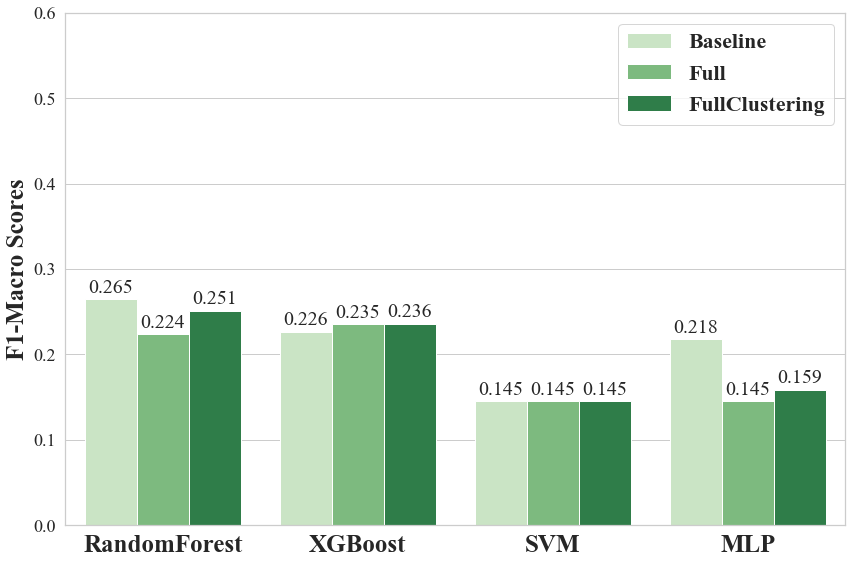

In [18]:
# F1 score comparison

plot_data = results.copy()

plot_data['Algorithm'] = plot_data['Model'].apply(lambda x: x.split(' (')[0])
plot_data['Feature_Set'] = plot_data['Model'].apply(lambda x: x.split(' (')[1].replace(')', ''))

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Times New Roman'  

ax = sns.barplot(
    data=plot_data, 
    x='Algorithm', 
    y='F1-Macro', 
    hue='Feature_Set', 
    palette='Greens'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=20, )

plt.xlabel(None)
plt.ylabel('F1-Macro Scores', fontsize=25, fontweight='bold')
plt.ylim(0, 0.6)
leg = plt.legend(loc='upper right', fontsize=22)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')
plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

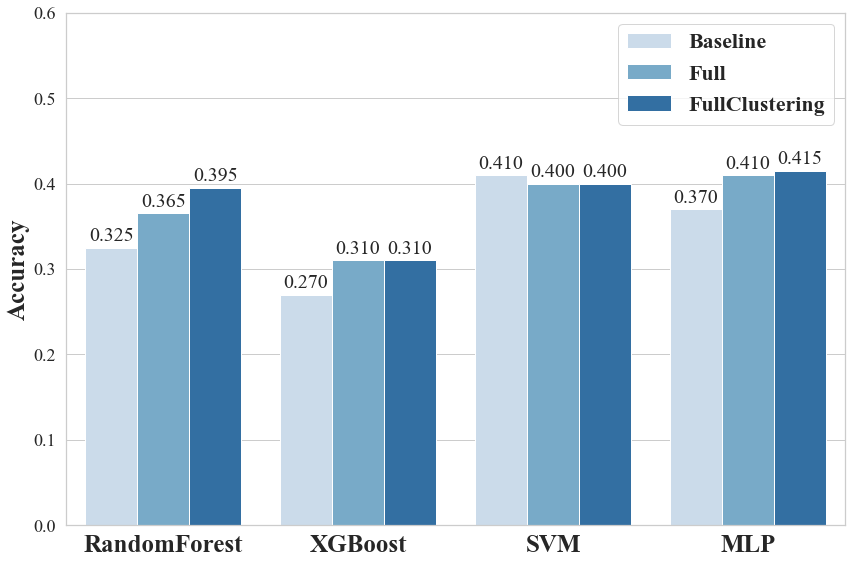

In [19]:
# Accuracy comparison

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Times New Roman'  

ax = sns.barplot(
    data=plot_data, 
    x='Algorithm', 
    y='Accuracy', 
    hue='Feature_Set', 
    palette='Blues'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=20)


plt.xlabel(None)
plt.ylabel('Accuracy', fontsize=25, fontweight='bold')
plt.ylim(0, 0.6)
leg = plt.legend(loc='upper right', fontsize=22)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')
plt.xticks(fontsize=25, fontweight='bold')
plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()

**Observations:**

Between-model Comparison:

* SVM and MLP achieved the highest Accuracy (~40%), but their F1-Macro scores are extremely low (~0.14). This indicates they are likely biased, predicting the majority class for almost every sample.

* Tree-Based Models (Random Forest (RF) and XGBoost) have a better balance between precision and recall across all four distinctive plant states.

Within-model Comparison:

* "Full+Cluster" feature set consistently outperforms the "Full" set. Unsupervised learning (K-Means) successfully captured latent structures that helped the supervised models make better decisions.

* "Full" feature set and "Full+Cluster" set generally outperforms the "baseline" set, indicating that the biological information is valuable.

Since our dataset only contains 1000 data points, F1 score is a better performance metric since it reveals how the model can balance between precision and recall.

Based on the analysis above, we select the "Full+Cluster" as our final feature set and XG Boost as our final best model.

In [20]:
# Best Model Selection for Final Plots
best_full_model = xgb_full_clus
best_model_name = "XG Boost (Full+Cluster)"

### 3.3.2 Feature importance

/var/folders/7w/3d5phc9d74z_t1zf0949fsrh0000gn/T/ipykernel_10396/3838643931.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Py

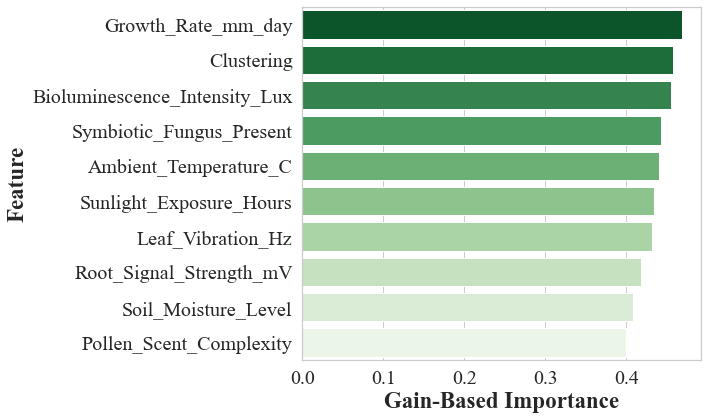

<Figure size 432x288 with 0 Axes>

In [21]:
# XGBoost Feature Importance (Gain/Entropy Contribution)
xgb_full_booster = xgb_full_clus.get_booster()
xgb_full_booster.feature_names = full_features_clustered 

xgb_full_importance = pd.Series(xgb_full_booster.get_score(importance_type='gain'), name='Importance')
xgb_full_importance.index.name = 'Feature'
xgb_full_importance = xgb_full_importance.reset_index().sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Importance',
    y='Feature',
    data=xgb_full_importance,
    palette='Greens_r'
)

ax.set_xlabel("Gain-Based Importance", fontsize=23, fontweight='bold')
ax.set_ylabel("Feature", fontsize=23, fontweight='bold')

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.tight_layout()
plt.show()
plt.clf()

# 4. Conclusion

## 4.1 Major Findings

**1. Model Effectiveness**

The **Full+Cluster** model, specifically **XG Boost (Full+Cluster)**, provides the optimal performance. 

**2. Clustering Effectiveness**

The **Cluster feature** is demonstrably **effective**, providing an **incremental performance lift** over the plain **Full** feature set. K-Means clustering identifies valuable, non-linear **latent groupings** in the bio-signal space that enhance the model's ability to discriminate between plant message types.

**3. Bio-signal Significance**

The performance gap between **Full** (Environmental + Bio-signals) and **Baseline** (Environmental only) validates the core hypothesis. The **bio-signals** provide critical, direct information that environmental factors alone cannot capture, making the Full model highly superior.

**4. Feature importance**

The top three features—Leaf_Vibration_Hz, Growth_Rate_mm_day, and Pollen_Scent_Complexity—are all biological or growth-related. This validates the project's hypothesis that internal plant bio-signals are slightly more predictive than external environmental factors (like temperature) for determining specific communication states.


## 4.2 Limitation

1. Unobserved Variables Leading to Sub-optimal AUC
key factors likely missing from the dataset include:

* **Temporal Dynamics:** The **sequence or change rate** of signals over time (e.g., time-series data) is ignored, which is often crucial for biological communication.
* **Internal State:** Unmeasured **hormone levels** or **cellular markers** that directly drive the communication message.
* **Microbial Interactions:** Unseen **microbial or fungal signals** influencing the plant's message generation.

2. Unbalance prediction

In [22]:
plt.figure(figsize=(8, 6))

ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=y_labels,
    yticklabels=y_labels,
    annot_kws={"size": 20}   
)


ax.set_xlabel("Predicted Label", fontsize=19,fontweight='bold',labelpad=12)
ax.set_ylabel("True Label", fontsize=19,fontweight='bold',labelpad=12)


ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)


cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)        

plt.tight_layout()
plt.show()
plt.clf()


NameError: name 'cm' is not defined

<Figure size 576x432 with 0 Axes>

The confusion matrix shows that the model only capture the pattern in the Distress group; for the other 3 groups, it doesn't really learn the pattern. Its behavior is like "predict whether the plant belongs to Distress first; if not, randomly assign it to one of the other 3 groups". This may due to the limited data size and the unbalance target variable distribution.

### 6. General Insights for Future Research 

* **Focus on Dynamics:** Future studies must incorporate **time-series analysis (RNNs/LSTMs)** to model the dynamic evolution of bio-signals.
* **Refine Feature Engineering:** Continue using **non-linear clustering** techniques to extract complex latent features, as validated by the **Cluster** feature's success.
* **Targeted Data Collection:** Prioritize measuring **internal physiological markers** over simple ambient environmental features to capture causal drivers of plant behavior.